In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
from datetime import datetime

In [2]:
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
tickets = first_table['Symbol'].values.tolist()
tickets.remove('BRK.B')
tickets.remove('BF.B')

In [3]:
all_stocks = []
for ticket in tickets:
    all_stocks.append(pd.read_csv('../datasets/yahoo/' + ticket + '.csv'))

In [9]:
def prepare_data(X, timerange=30, split=0.1):
    
    train_size = int(X.shape[0] * (1 - split))
    train_size = min(train_size, X.shape[0] - timerange)
    
    test_size = X.shape[0] - train_size - timerange
    
    X_train = np.ndarray(shape=(train_size, timerange))
    Y_train = np.ndarray(shape=(train_size))
    for i in range(train_size):
        X_train[i] = X[i:i+timerange]
        Y_train[i] = X[i+timerange]
    
    X_test = np.ndarray(shape=(test_size, timerange))
    Y_test = np.ndarray(shape=(test_size))
    for i in range(test_size):
        X_test[i] = X[train_size+i:train_size+i+timerange]
        Y_test[i] = X[train_size+i+timerange]
    
    return X_train, Y_train, X_test, Y_test
    

In [10]:
X_train, X_test = [np.ndarray(shape=(0, 30)) for i in range(2)]
Y_train, Y_test = [np.ndarray(shape=(0)) for i in range(2)]
for stock in all_stocks:
    x_train, y_train, x_test, y_test = prepare_data(stock['Close'].copy())
    X_train = np.append(X_train, x_train, axis=0)
    Y_train = np.append(Y_train, y_train, axis=0)
    X_test = np.append(X_test, x_test, axis=0)
    Y_test = np.append(Y_test, y_test, axis=0)

In [11]:
X_train.shape, Y_train.shape

((227367, 30), (227367,))

In [12]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression(n_jobs=-1)
model_LR.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [13]:
conf = model_LR.score(X_test, Y_test)
conf

0.9994860895187114

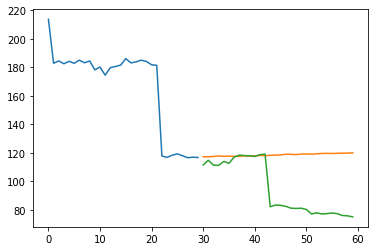

In [14]:
history_size = 30
num_points = 30

offset = 4045

preds = np.ndarray(shape=(num_points))

curr_history = X_test[-1-offset:X_test.shape[0]-offset].copy()

for i in range(preds.shape[0]):
    preds[i] = model_LR.predict(curr_history)[0]
    curr_history[0][:-1] = curr_history[0][1:]
    curr_history[0][-1] = preds[i]

plt.plot([i for i in range(history_size)], Y_test[-history_size-offset:Y_test.shape[0]-offset])
plt.plot([i for i in range(history_size, history_size + num_points)], preds)

plt.plot([i for i in range(history_size, history_size + num_points)],
         Y_test[Y_test.shape[0]-offset:Y_test.shape[0]-offset+num_points])

plt.show()

In [15]:
Y_test[-num_points:], preds[-num_points:]

(array([ 45.79999924,  46.02999878,  48.22000122,  47.72999954,
         48.65000153,  49.59000015,  49.58000183,  48.90999985,
         49.22999954, 160.96000671, 161.55999756, 162.57000732,
        163.36000061, 164.46000671, 163.33000183, 161.33999634,
        159.71000671, 153.1499939 , 156.52999878, 154.25      ,
        155.58000183, 157.38999939, 155.22999573, 157.13000488,
        159.27999878, 160.02000427, 159.83000183, 160.61999512,
        164.44000244, 166.60499573]),
 array([117.23903632, 117.24598358, 117.43585868, 117.79336827,
        117.51226506, 117.69711332, 117.51381591, 117.5350637 ,
        117.85942082, 117.71887846, 117.86605514, 118.15676976,
        118.02388191, 118.23253634, 118.39765587, 118.52191221,
        119.00103633, 118.94128295, 118.7561663 , 119.09561222,
        119.17983493, 119.09603943, 119.26481064, 119.55265883,
        119.61060084, 119.53942727, 119.65380577, 119.75551087,
        119.82384678, 119.94853686]))

In [16]:
from sklearn.neighbors import KNeighborsRegressor

clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [17]:
confidenceknn = clfknn.score(X_test, Y_test)

In [18]:
confidenceknn

0.9958576589259663

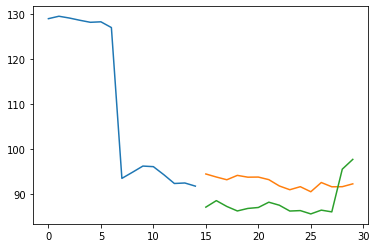

In [20]:
history_size = 15
num_points = 15

offset = 2638

preds = np.ndarray(shape=(num_points))

curr_history = X_test[-1-offset:X_test.shape[0]-offset].copy()

for i in range(preds.shape[0]):
    preds[i] = clfknn.predict(curr_history)[0]
    curr_history[0][:-1] = curr_history[0][1:]
    curr_history[0][-1] = preds[i]

plt.plot([i for i in range(history_size)], Y_test[-history_size-offset:Y_test.shape[0]-offset])
plt.plot([i for i in range(history_size, history_size + num_points)], preds)

plt.plot([i for i in range(history_size, history_size + num_points)],
         Y_test[Y_test.shape[0]-offset:Y_test.shape[0]-offset+num_points])

plt.show()

In [21]:
count = X_test.shape[0]
preds = clfknn.predict(X_test)
correct = 0

for i in range(count):
    correct += (np.sign(X_test[i][-1] - preds[i]) == np.sign(X_test[i][-1] - Y_test[i]))
    
print('KNN correct: %d/%d' % (correct, count))

preds = model_LR.predict(X_test)
correct = 0

for i in range(count):
    correct += (np.sign(X_test[i][-1] - preds[i]) == np.sign(X_test[i][-1] - Y_test[i]))
    
print('LR correct: %d/%d' % (correct, count))

KNN correct: 5165/10445
LR correct: 5665/10445
